In [192]:
from tqdm import tqdm
import copy
import time
import functools
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score


In [116]:
def timeit(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()  
        result = func(*args, **kwargs)  
        end_time = time.time()  
        execution_time = end_time - start_time  
        print(f"Function '{func.__name__}' executed in {execution_time:.4f} seconds")
        return result
    return wrapper

In [79]:
class PlainCNN(nn.Module):
    def __init__(self):
        super(PlainCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 28 * 28, 102)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [129]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, num_classes=101):
        super(ResNetFeatureExtractor, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


        for param in self.resnet.parameters():
            param.requires_grad = False
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
        num_features = self.resnet.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [190]:
class ResNet(nn.Module):
    def __init__(self, num_classes=101):
        super(ResNet, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)

        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [80]:
# check if runs on Apple Silicon efficiently

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    raise Exception("MPS not available")

else:
    device = torch.device("mps")
    print("MPS enabled")

MPS enabled


In [82]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [83]:
train_dataset = datasets.Caltech101(
    root='./data', 
    download=True, 
    transform=transform, 
    target_type='category'
)

Files already downloaded and verified


In [106]:
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [107]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


X.size()=torch.Size([64, 1, 224, 224]), y.size()=torch.Size([64])
label: tensor(75)


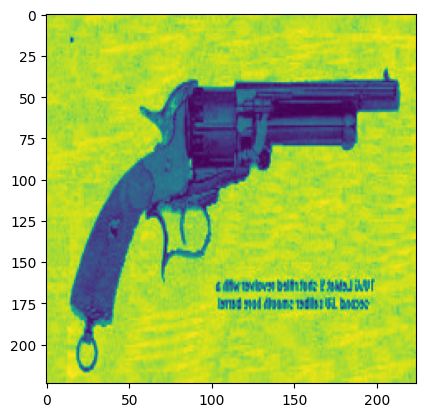

In [87]:
for X, y in train_loader:
    print(f"\n{X.size()=},{ y.size()=}")
    print("label:", y[1])

    # imshow expect image in shape (height, width, channels)!
    plt.imshow(X[1].permute(1, 2, 0))
    break

In [117]:
@timeit
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs = 10):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    patience = 0
    
    model = model.to(device)
    
    train_accuracy_history = []
    val_accuracy_history = []
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_total = 0
        train_correct = 0
        with tqdm(total=len(train_loader), desc="Training Batches", leave=False) as pbar:
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                training_loss = criterion(outputs, labels)
                training_loss.backward()
                optimizer.step()
                running_train_loss += training_loss.item() * inputs.size(0)
                pbar.update(1)
    
        train_accuracy = train_correct / train_total
        train_accuracy_history.append(train_accuracy)
        train_epoch_loss = running_train_loss / len(train_loader.dataset)
        train_loss_history.append(train_epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}')
        print(f'Training Accuracy: {train_accuracy:.4f}')
        print(f'Training Loss: {train_epoch_loss:.4f}')
        
        model.eval()
        val_correct = 0
        val_total = 0
        running_val_loss = 0
        with torch.no_grad():
            with tqdm(total=len(val_loader), desc="Validating Batches", leave=False) as pbar:
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    
                    val_loss = criterion(outputs, labels)
                    running_val_loss += val_loss.item() * inputs.size(0) 
                    
                    pbar.update(1)
        
        val_accuracy = val_correct / val_total
        val_accuracy_history.append(val_accuracy)
        val_epoch_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(val_epoch_loss)
        if best_accuracy >= val_accuracy:
            patience += 1
            if patience > 5:
                break
        else:
            best_accuracy = val_accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
            patience = 0
                
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation Loss: {val_epoch_loss:.4f}')
        print('=' * 80)
    
    print('Training complete')
    
    return {
        'train_accuracy_history': train_accuracy_history,
        'train_loss_history': train_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'val_loss_history': val_loss_history,
        'best_model_weights': best_model_weights,
        'best_model': copy.deepcopy(model.state_dict()),
    }

In [220]:
models_to_train = {
    'plain_cnn': PlainCNN, 
    'frozen_resnet': ResNetFeatureExtractor, 
    'resnet': ResNet
}
models_results = {}
criterion = nn.CrossEntropyLoss()
for name, model in models_to_train.items():
    model = model()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"Training the model {name}")
    model_results = train_model(
        model, train_loader, val_loader, optimizer, criterion, num_epochs = 25
    )
    print(f"Saving the model {name}")
    torch.save(
        model_results.get('best_model_weights'), 
        f'{name}_model_weights.pth'
    )
    models_results[name] = model_results

Training the model plain_cnn


Epoch 1/25, Training Loss: 3.7284
Training Accuracy: 0.2441
Training Loss: 3.7284


Validation Accuracy: 0.3570
Validation Loss: 3.2025


Epoch 2/25, Training Loss: 2.1583
Training Accuracy: 0.5250
Training Loss: 2.1583


Validation Accuracy: 0.4707
Validation Loss: 2.6347


Epoch 3/25, Training Loss: 0.8871
Training Accuracy: 0.7837
Training Loss: 0.8871


Validation Accuracy: 0.4809
Validation Loss: 2.9384


Epoch 4/25, Training Loss: 0.2190
Training Accuracy: 0.9494
Training Loss: 0.2190


Validation Accuracy: 0.4899
Validation Loss: 3.8458


Epoch 5/25, Training Loss: 0.0702
Training Accuracy: 0.9840
Training Loss: 0.0702


Validation Accuracy: 0.4955
Validation Loss: 4.1571


Epoch 6/25, Training Loss: 0.0269
Training Accuracy: 0.9969
Training Loss: 0.0269


Validation Accuracy: 0.4944
Validation Loss: 4.1511


Epoch 7/25, Training Loss: 0.0257
Training Accuracy: 0.9966
Training Loss: 0.0257


Validation Accuracy: 0.4989
Validation Loss: 4.2773


Epoch 8/25, Training Loss: 0.0167
Training Accuracy: 0.9978
Training Loss: 0.0167


Validation Accuracy: 0.4977
Validation Loss: 3.9209


Epoch 9/25, Training Loss: 0.0140
Training Accuracy: 0.9986
Training Loss: 0.0140


Validation Accuracy: 0.4977
Validation Loss: 3.8382


Epoch 10/25, Training Loss: 0.0067
Training Accuracy: 0.9992
Training Loss: 0.0067


Validation Accuracy: 0.5068
Validation Loss: 3.8688


Epoch 11/25, Training Loss: 0.0120
Training Accuracy: 0.9992
Training Loss: 0.0120


Validation Accuracy: 0.5101
Validation Loss: 3.7344


Epoch 12/25, Training Loss: 0.0095
Training Accuracy: 0.9992
Training Loss: 0.0095


Validation Accuracy: 0.5079
Validation Loss: 3.7036


Epoch 13/25, Training Loss: 0.0118
Training Accuracy: 0.9992
Training Loss: 0.0118


Validation Accuracy: 0.5169
Validation Loss: 3.6492


Epoch 14/25, Training Loss: 0.0085
Training Accuracy: 0.9994
Training Loss: 0.0085


Validation Accuracy: 0.5068
Validation Loss: 3.8296


Epoch 15/25, Training Loss: 0.0094
Training Accuracy: 0.9992
Training Loss: 0.0094


Validation Accuracy: 0.5101
Validation Loss: 3.7753


Epoch 16/25, Training Loss: 0.0082
Training Accuracy: 0.9992
Training Loss: 0.0082


Validation Accuracy: 0.5169
Validation Loss: 3.6055


Epoch 17/25, Training Loss: 0.0083
Training Accuracy: 0.9992
Training Loss: 0.0083


Validation Accuracy: 0.5191
Validation Loss: 3.7178


Epoch 18/25, Training Loss: 0.0049
Training Accuracy: 0.9994
Training Loss: 0.0049


Validation Accuracy: 0.5113
Validation Loss: 3.6627


Epoch 19/25, Training Loss: 0.0082
Training Accuracy: 0.9992
Training Loss: 0.0082


Validation Accuracy: 0.5135
Validation Loss: 3.6953


Epoch 20/25, Training Loss: 0.0045
Training Accuracy: 0.9992
Training Loss: 0.0045


Validation Accuracy: 0.5135
Validation Loss: 3.6092


Epoch 21/25, Training Loss: 0.0060
Training Accuracy: 0.9994
Training Loss: 0.0060


Validation Accuracy: 0.5011
Validation Loss: 3.9803


Epoch 22/25, Training Loss: 0.0087
Training Accuracy: 0.9992
Training Loss: 0.0087


Validation Accuracy: 0.5090
Validation Loss: 3.3687


Epoch 23/25, Training Loss: 0.0089
Training Accuracy: 0.9992
Training Loss: 0.0089


Training complete
Function 'train_model' executed in 1134.6659 seconds
Saving the model plain_cnn
Training the model frozen_resnet


Epoch 1/25, Training Loss: 3.6529
Training Accuracy: 0.2520
Training Loss: 3.6529


Validation Accuracy: 0.2905
Validation Loss: 3.3982


Epoch 2/25, Training Loss: 2.7953
Training Accuracy: 0.3861
Training Loss: 2.7953


Validation Accuracy: 0.3851
Validation Loss: 2.7643


Epoch 3/25, Training Loss: 2.2374
Training Accuracy: 0.4975
Training Loss: 2.2374


Validation Accuracy: 0.4741
Validation Loss: 2.3558


Epoch 4/25, Training Loss: 1.8798
Training Accuracy: 0.5751
Training Loss: 1.8798


Validation Accuracy: 0.5090
Validation Loss: 2.1603


Epoch 5/25, Training Loss: 1.6047
Training Accuracy: 0.6271
Training Loss: 1.6047


Validation Accuracy: 0.5169
Validation Loss: 2.0301


Epoch 6/25, Training Loss: 1.4142
Training Accuracy: 0.6623
Training Loss: 1.4142


Validation Accuracy: 0.5529
Validation Loss: 1.8742


Epoch 7/25, Training Loss: 1.2535
Training Accuracy: 0.6974
Training Loss: 1.2535


Validation Accuracy: 0.5574
Validation Loss: 1.7879


Epoch 8/25, Training Loss: 1.1063
Training Accuracy: 0.7337
Training Loss: 1.1063


Validation Accuracy: 0.5732
Validation Loss: 1.7558


Epoch 9/25, Training Loss: 0.9982
Training Accuracy: 0.7643
Training Loss: 0.9982


Validation Accuracy: 0.5867
Validation Loss: 1.6755


Epoch 10/25, Training Loss: 0.9011
Training Accuracy: 0.7781
Training Loss: 0.9011


Validation Accuracy: 0.5788
Validation Loss: 1.7050


Epoch 11/25, Training Loss: 0.8172
Training Accuracy: 0.7989
Training Loss: 0.8172


Validation Accuracy: 0.5968
Validation Loss: 1.7114


Epoch 12/25, Training Loss: 0.7510
Training Accuracy: 0.8209
Training Loss: 0.7510


Validation Accuracy: 0.5946
Validation Loss: 1.6988


Epoch 13/25, Training Loss: 0.6820
Training Accuracy: 0.8431
Training Loss: 0.6820


Validation Accuracy: 0.5766
Validation Loss: 1.7247


Epoch 14/25, Training Loss: 0.6325
Training Accuracy: 0.8529
Training Loss: 0.6325


Validation Accuracy: 0.5991
Validation Loss: 1.6612


Epoch 15/25, Training Loss: 0.5431
Training Accuracy: 0.8729
Training Loss: 0.5431


Validation Accuracy: 0.6025
Validation Loss: 1.6640


Epoch 16/25, Training Loss: 0.5171
Training Accuracy: 0.8847
Training Loss: 0.5171


Validation Accuracy: 0.6002
Validation Loss: 1.6614


Epoch 17/25, Training Loss: 0.5001
Training Accuracy: 0.8822
Training Loss: 0.5001


Validation Accuracy: 0.5912
Validation Loss: 1.6983


Epoch 18/25, Training Loss: 0.4353
Training Accuracy: 0.9049
Training Loss: 0.4353


Validation Accuracy: 0.6002
Validation Loss: 1.7217


Epoch 19/25, Training Loss: 0.3779
Training Accuracy: 0.9204
Training Loss: 0.3779


Validation Accuracy: 0.6081
Validation Loss: 1.6980


Epoch 20/25, Training Loss: 0.3689
Training Accuracy: 0.9170
Training Loss: 0.3689


Validation Accuracy: 0.5980
Validation Loss: 1.7323


Epoch 21/25, Training Loss: 0.3459
Training Accuracy: 0.9260
Training Loss: 0.3459


Validation Accuracy: 0.6025
Validation Loss: 1.7022


Epoch 22/25, Training Loss: 0.3017
Training Accuracy: 0.9418
Training Loss: 0.3017


Validation Accuracy: 0.5878
Validation Loss: 1.7639


Epoch 23/25, Training Loss: 0.2820
Training Accuracy: 0.9435
Training Loss: 0.2820


Validation Accuracy: 0.5957
Validation Loss: 1.7857


Epoch 24/25, Training Loss: 0.2679
Training Accuracy: 0.9477
Training Loss: 0.2679


Validation Accuracy: 0.5845
Validation Loss: 1.8115


Epoch 25/25, Training Loss: 0.2581
Training Accuracy: 0.9488
Training Loss: 0.2581


Training complete
Function 'train_model' executed in 1416.3482 seconds
Saving the model frozen_resnet
Training the model resnet


Epoch 1/25, Training Loss: 2.9262
Training Accuracy: 0.3825
Training Loss: 2.9262


Validation Accuracy: 0.4088
Validation Loss: 2.6272


Epoch 2/25, Training Loss: 1.8260
Training Accuracy: 0.5621
Training Loss: 1.8260


Validation Accuracy: 0.4786
Validation Loss: 2.0585


Epoch 3/25, Training Loss: 1.1325
Training Accuracy: 0.7044
Training Loss: 1.1325


Validation Accuracy: 0.6453
Validation Loss: 1.4729


Epoch 4/25, Training Loss: 0.6966
Training Accuracy: 0.8043
Training Loss: 0.6966


Validation Accuracy: 0.6667
Validation Loss: 1.2942


Epoch 5/25, Training Loss: 0.4568
Training Accuracy: 0.8735
Training Loss: 0.4568


Validation Accuracy: 0.7050
Validation Loss: 1.2263


Epoch 6/25, Training Loss: 0.2819
Training Accuracy: 0.9241
Training Loss: 0.2819


Validation Accuracy: 0.6689
Validation Loss: 1.5371


Epoch 7/25, Training Loss: 0.1878
Training Accuracy: 0.9466
Training Loss: 0.1878


Validation Accuracy: 0.7140
Validation Loss: 1.2456


Epoch 8/25, Training Loss: 0.1183
Training Accuracy: 0.9716
Training Loss: 0.1183


Validation Accuracy: 0.7444
Validation Loss: 1.1370


Epoch 9/25, Training Loss: 0.0580
Training Accuracy: 0.9868
Training Loss: 0.0580


Validation Accuracy: 0.7703
Validation Loss: 1.0678


Epoch 10/25, Training Loss: 0.0330
Training Accuracy: 0.9938
Training Loss: 0.0330


Validation Accuracy: 0.8029
Validation Loss: 0.8123


Epoch 11/25, Training Loss: 0.0189
Training Accuracy: 0.9958
Training Loss: 0.0189


Validation Accuracy: 0.8063
Validation Loss: 0.9059


Epoch 12/25, Training Loss: 0.0399
Training Accuracy: 0.9924
Training Loss: 0.0399


Validation Accuracy: 0.7444
Validation Loss: 1.1736


Epoch 13/25, Training Loss: 0.0734
Training Accuracy: 0.9792
Training Loss: 0.0734


Validation Accuracy: 0.7556
Validation Loss: 1.0951


Epoch 14/25, Training Loss: 0.1197
Training Accuracy: 0.9691
Training Loss: 0.1197


Validation Accuracy: 0.6824
Validation Loss: 1.5070


Epoch 15/25, Training Loss: 0.1962
Training Accuracy: 0.9457
Training Loss: 0.1962


Validation Accuracy: 0.6993
Validation Loss: 1.3078


Epoch 16/25, Training Loss: 0.1255
Training Accuracy: 0.9620
Training Loss: 0.1255


Validation Accuracy: 0.7545
Validation Loss: 1.0116


Epoch 17/25, Training Loss: 0.0543
Training Accuracy: 0.9859
Training Loss: 0.0543


Training complete
Function 'train_model' executed in 1338.8247 seconds
Saving the model resnet


In [132]:
def load_model_weights(model_class, model_weights):
    model = model_class()
    model.load_state_dict(model_weights)
    model = model.to(device)
    model.eval()
    return model

In [155]:
def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)


In [138]:
def generate_classification_report(labels, preds):
    report = classification_report(labels, preds, output_dict=True)
    print(classification_report(labels, preds))
    return report

In [137]:
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(15, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.show()

In [145]:
def plot_learning_curves(train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history):
    epochs = range(1, len(train_accuracy_history) + 1)
    plt.figure(figsize=(15, 15))
    plt.plot(epochs, train_accuracy_history, label='Training accuracy')
    plt.plot(epochs, val_accuracy_history, label='Validation accuracy')
    plt.title('Learning Curves: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss_history, label='Training loss')
    plt.plot(epochs, val_loss_history, label='Validation loss')
    plt.title('Learning Curves: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [161]:
def plot_roc_curve(labels, preds, num_classes=101):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), (preds == i).astype(int))
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 10))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right").remove()
    plt.show()

In [162]:
def plot_prc_curve(labels, preds, num_classes=101):
    precision = dict()
    recall = dict()
    prc_auc = dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve((labels == i).astype(int), (preds == i).astype(int))
        prc_auc[i] = auc(recall[i], precision[i])

    plt.figure(figsize=(10, 10))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (area = {prc_auc[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right").remove()
    plt.show()

In [177]:
def visualize_filters(layer, title):
    filters = layer.weight.data.cpu().numpy()
    filters = filters - filters.min()
    filters = filters / filters.max()
    num_filters = filters.shape[0]
    num_channels = filters.shape[1]
    
    fig, axes = plt.subplots(num_filters, num_channels, figsize=(16, 12))
    
    for i in range(num_filters):
        for j in range(num_channels):
            plt.subplot(num_filters, num_channels, i * num_channels + j + 1)
            plt.imshow(filters[i, j], cmap='gray')
            plt.axis('off')
    
    fig.suptitle(title)
    plt.show()

In [206]:
def visualize_feature_maps(model, layer, input_image, title):
    model.eval()
    with torch.no_grad():
        x = input_image.unsqueeze(0).to(device)
        if 'conv1' in layer:
            if layer == 'conv1':
                feature_maps = model.conv1(x)
            elif layer == 'resnet.conv1':
                feature_maps = model.resnet.conv1(x)
                
        elif 'conv2' in layer:
            if layer == 'conv2':
                x = F.relu(model.conv1(x))
                x = F.max_pool2d(x, 2)
                feature_maps = model.conv2(x)
            elif layer == 'resnet.conv2':
                x = F.relu(model.resnet.conv1(x))
                x = F.max_pool2d(x, 2)
                feature_maps = model.resnet.conv2(x)
            
        feature_maps = feature_maps.cpu().numpy()[0]
    
    num_feature_maps = feature_maps.shape[0]
    
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(8, 12))
    
    for i in range(num_feature_maps):
        axes[i].imshow(feature_maps[i], cmap='gray')
        axes[i].axis('off')
    
    fig.suptitle(title)
    plt.show()

In [184]:
def get_test_image(data_loader):
    data_iterator = iter(data_loader)
    images, _ = next(data_iterator)
    image = images[0]

    return image

In [214]:
def evaluate_model(model_results, val_loader, train_loader, model_class):
    model = load_model_weights(model_class, model_results['best_model_weights'])
    print(f"Evaluating the model {model}")
    
    train_preds, train_labels = get_all_preds(model, train_loader)
    val_preds, val_labels = get_all_preds(model, val_loader)

    print("Training Classification Report")
    train_report = generate_classification_report(train_labels, train_preds)
    print(train_report)

    print("Validation Classification Report")
    val_report = generate_classification_report(val_labels, val_preds)
    print(val_report)

    print("Training Confusion Matrix")
    plot_confusion_matrix(train_labels, train_preds, "Training Confusion Matrix")

    print("Validation Confusion Matrix")
    plot_confusion_matrix(val_labels, val_preds, "Validation Confusion Matrix")

    plot_learning_curves(
        model_results['train_accuracy_history'], 
        model_results['val_accuracy_history'], 
        model_results['train_loss_history'], 
        model_results['val_loss_history']
    )

    plot_roc_curve(train_labels, train_preds)
    plot_roc_curve(val_labels, val_preds)

    plot_prc_curve(train_labels, train_preds)
    plot_prc_curve(val_labels, val_preds)

    # Top-1 error rate
    train_top1_error = 1 - train_report['accuracy']
    val_top1_error = 1 - val_report['accuracy']

    print(f'Training Top-1 Error Rate: {train_top1_error * 100:.2f}%')
    print(f'Validation Top-1 Error Rate: {val_top1_error * 100:.2f}%')
    
    val_image = get_test_image(val_loader)
    
    if isinstance(model, PlainCNN):
        layer1 = model.conv1
        layer1_str = 'conv1'
        layer2 = model.conv2        
        layer2_str = 'conv2'
        visualize_filters(layer1, 'First Conv Layer Filters')
        visualize_feature_maps(model, layer1_str, val_image, 'First Conv Layer Feature Maps')
        
        visualize_filters(layer2, 'Second Conv Layer Filters')
        visualize_feature_maps(model, layer2_str, val_image, 'Second Conv Layer Feature Maps')
    else:
        layer1 = model.resnet.conv1
        layer1_str = 'resnet.conv1'
        
        visualize_filters(layer1, 'First Conv Layer Filters')
        visualize_feature_maps(model, layer1_str, val_image, 'First Conv Layer Feature Maps')


Evaluating the model plain_cnn
Evaluating the model PlainCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=50176, out_features=102, bias=True)
)
Training Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       179
           1       1.00      0.99      0.99       177
           2       1.00      1.00      1.00        89
           3       1.00      1.00      1.00       338
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        21
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        19
          10     

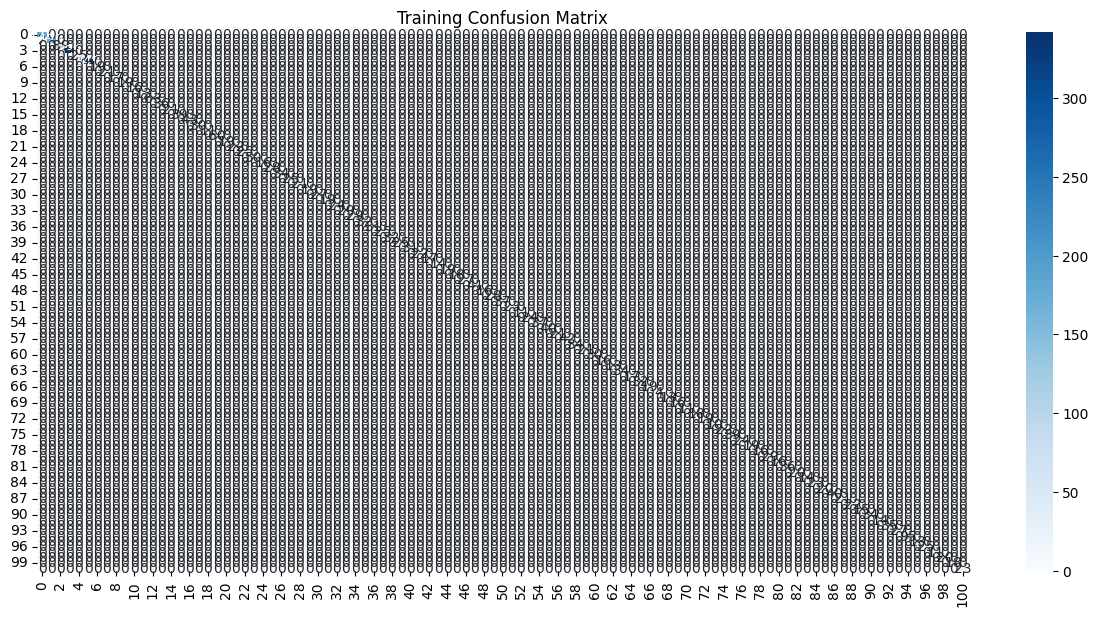

Validation Confusion Matrix


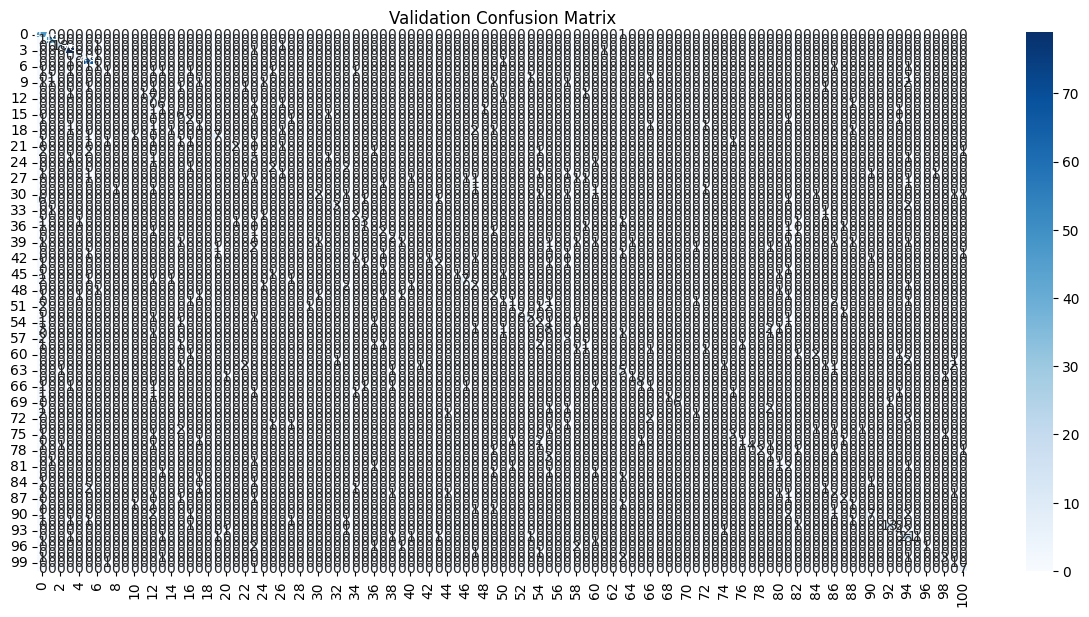

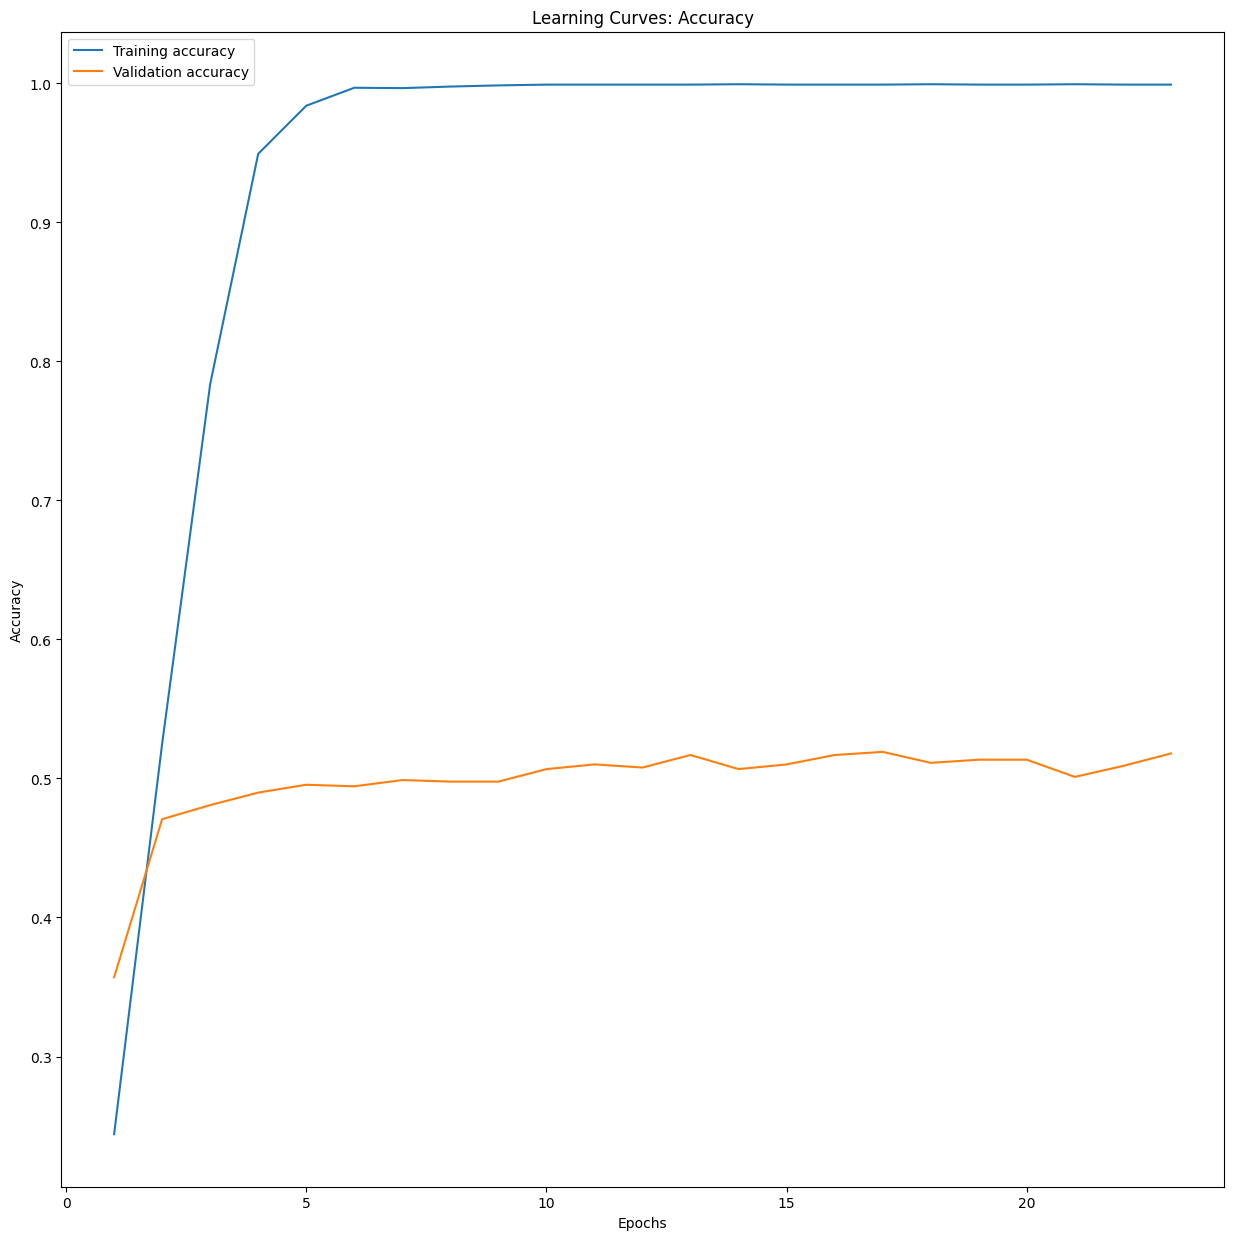

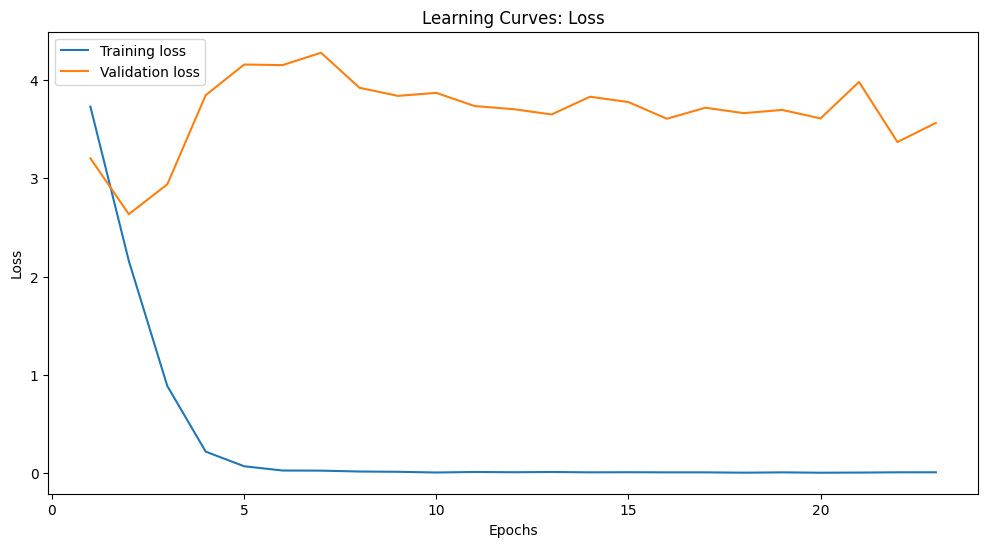

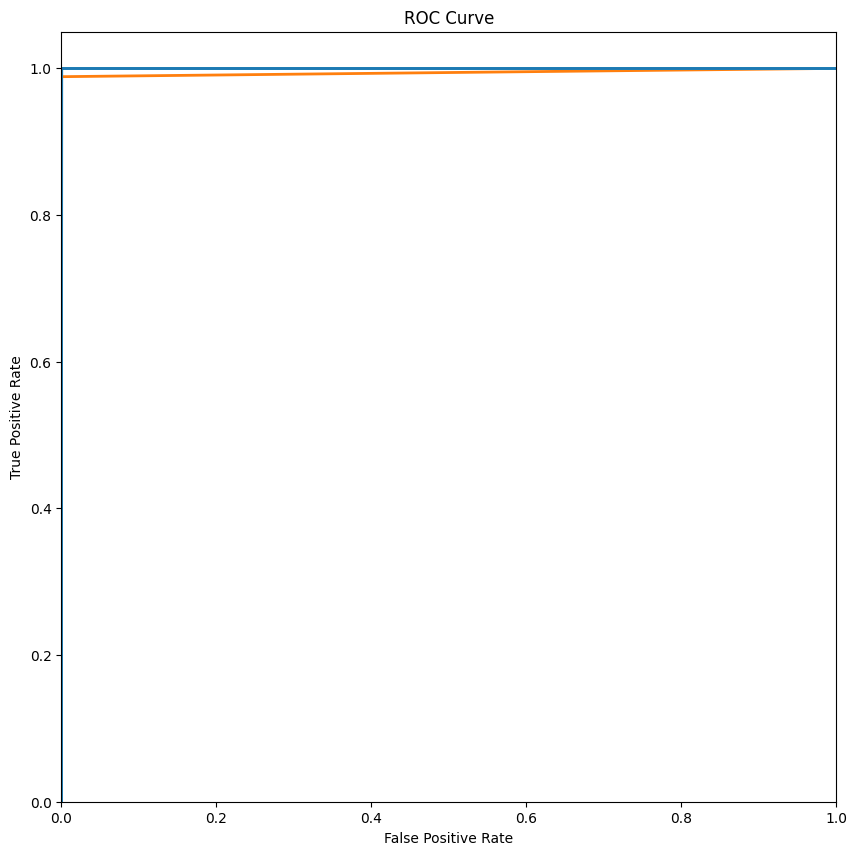

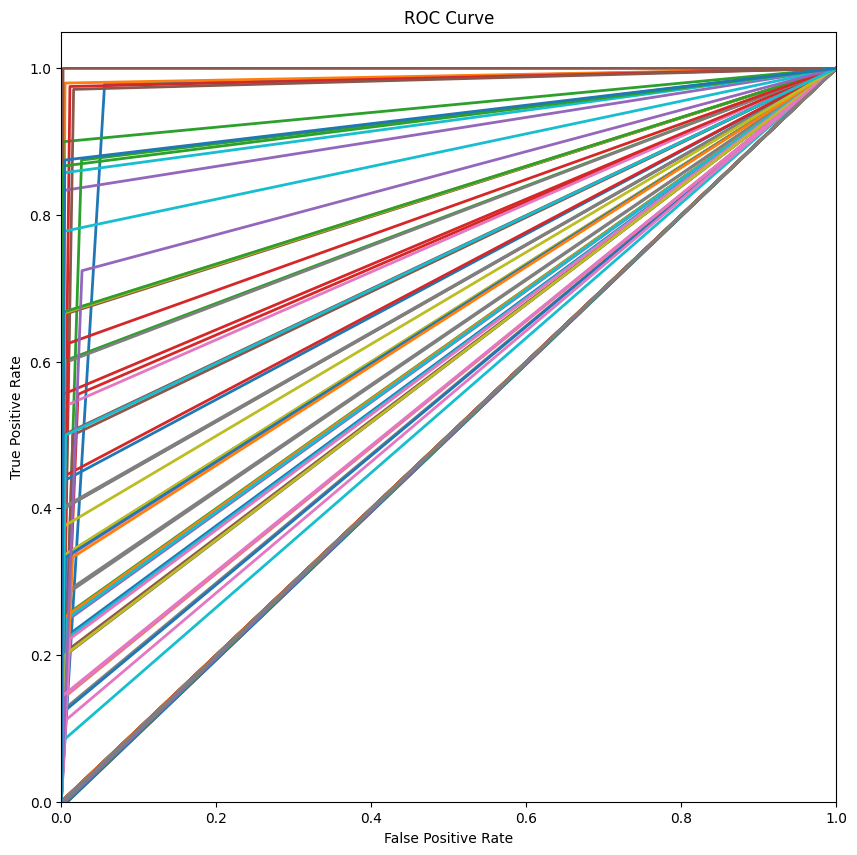

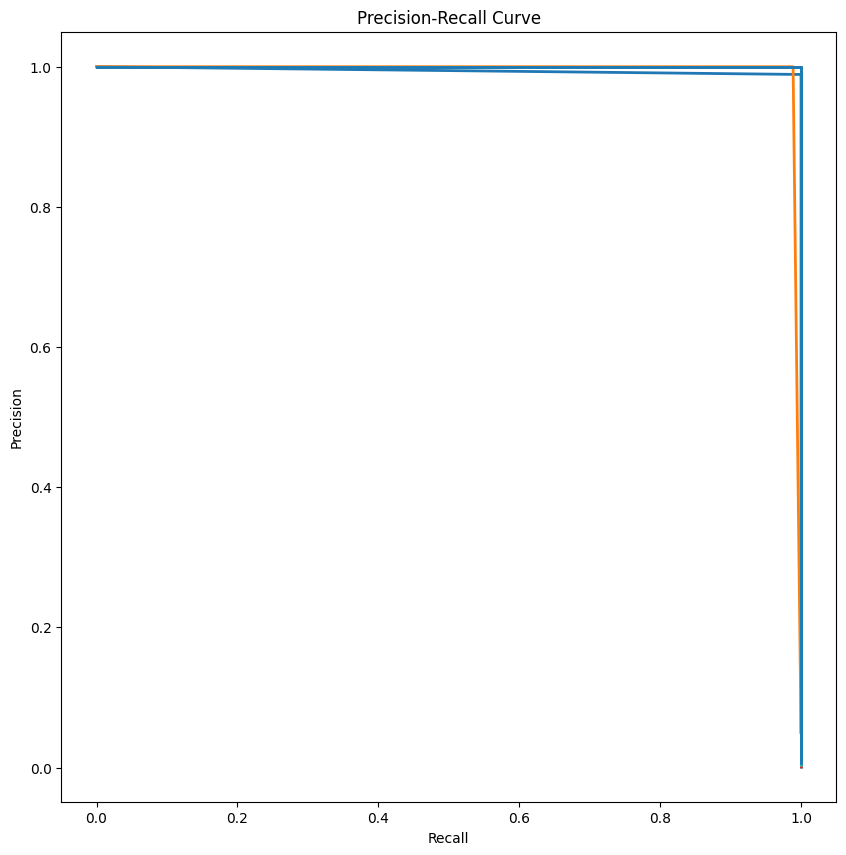

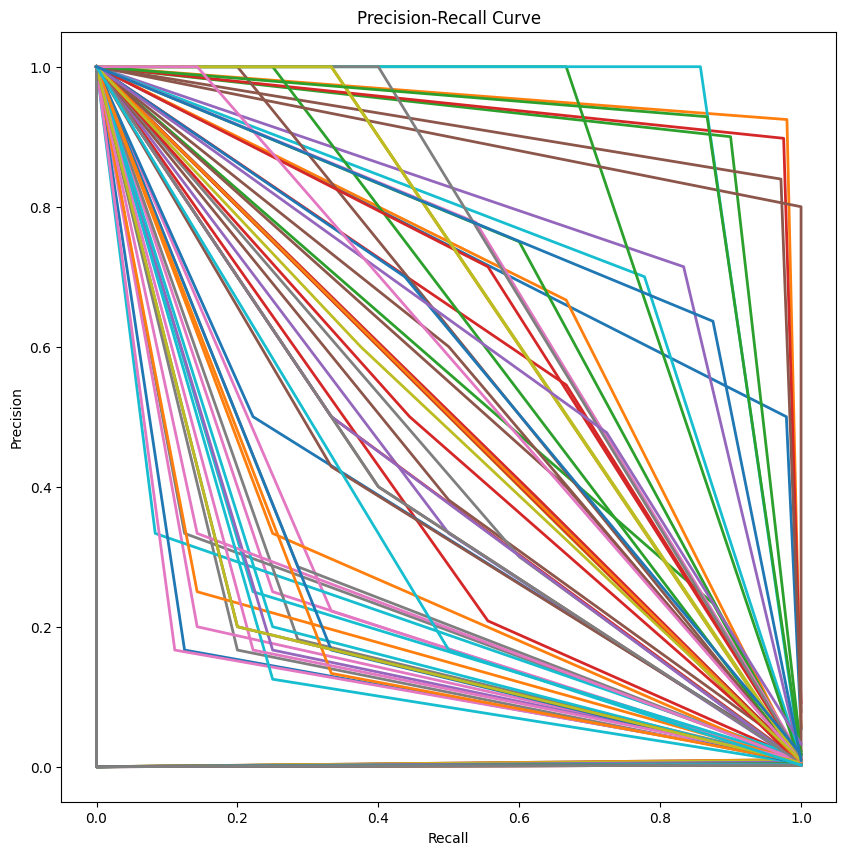

Training Top-1 Error Rate: 0.06%
Validation Top-1 Error Rate: 48.09%


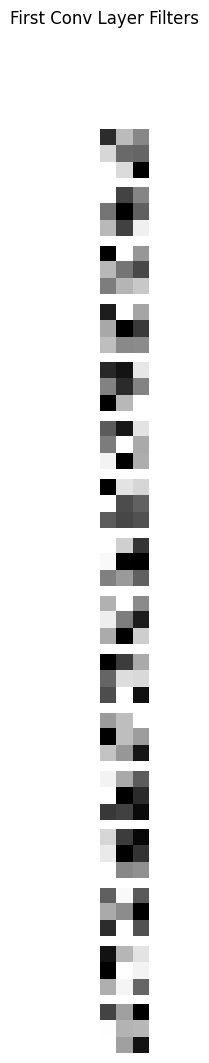

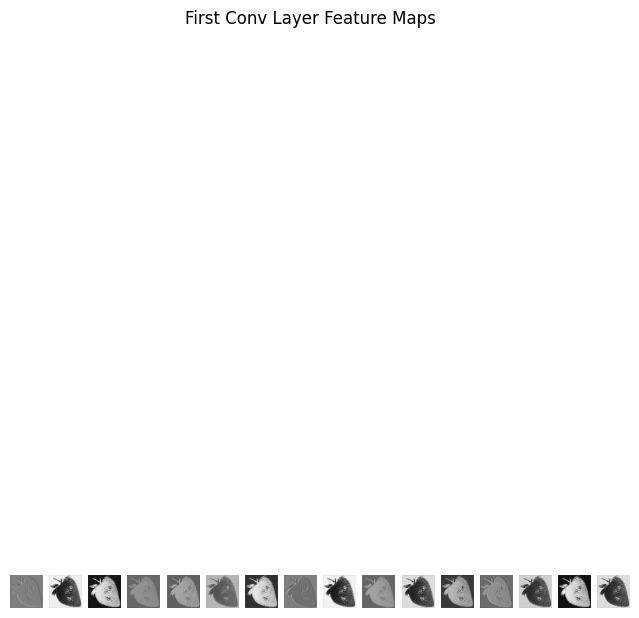

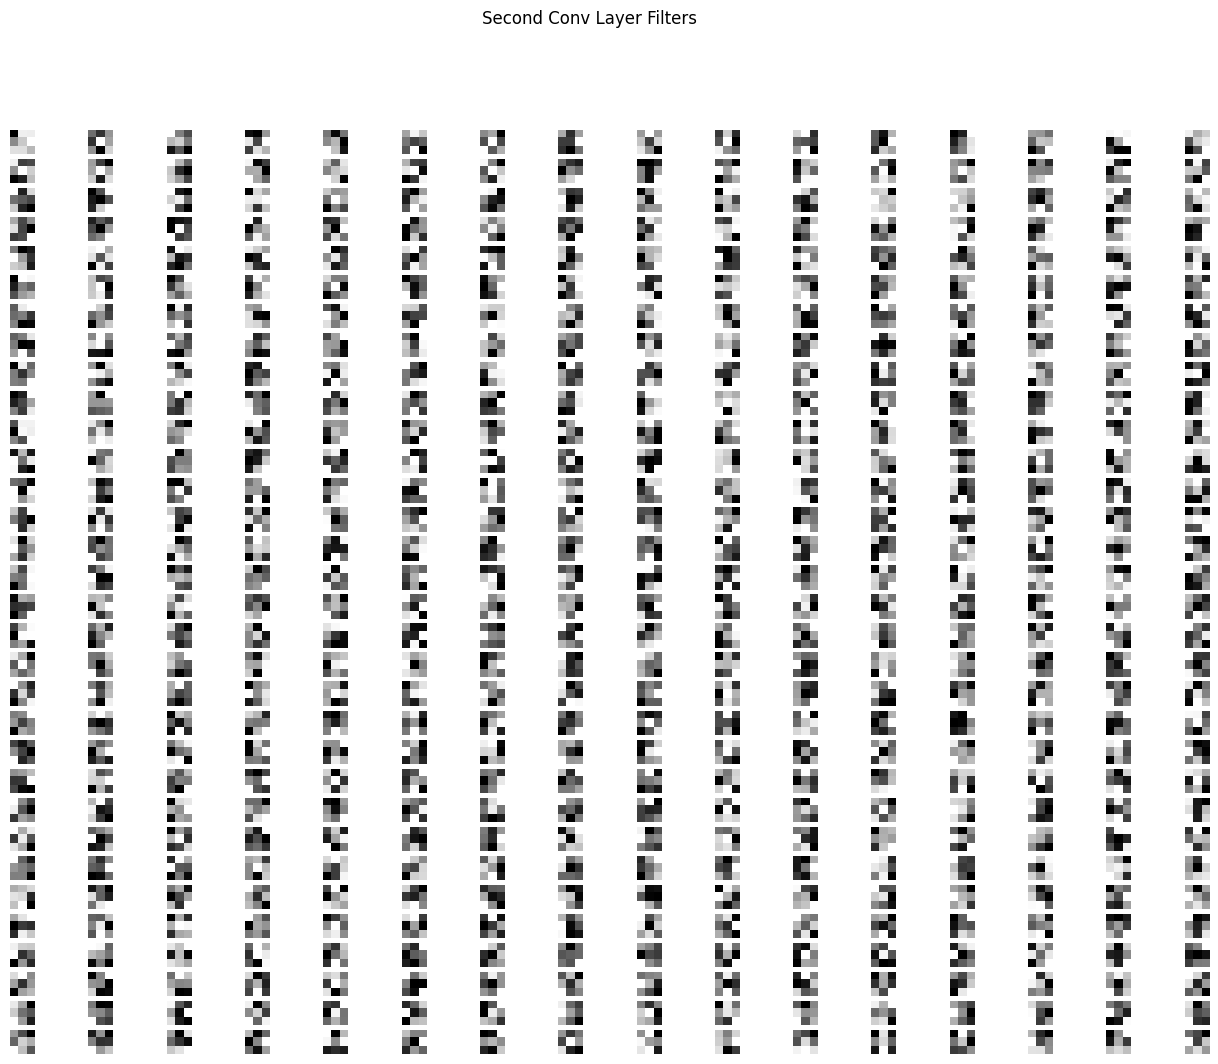

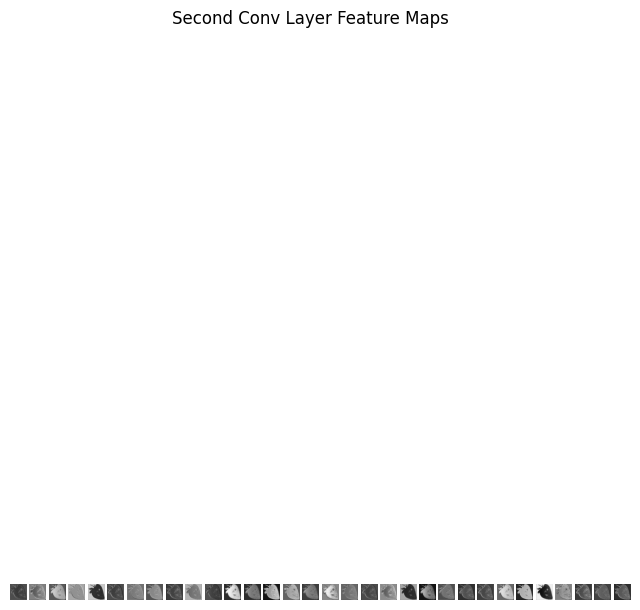

Evaluating the model frozen_resnet
Evaluating the model ResNetFeatureExtractor(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

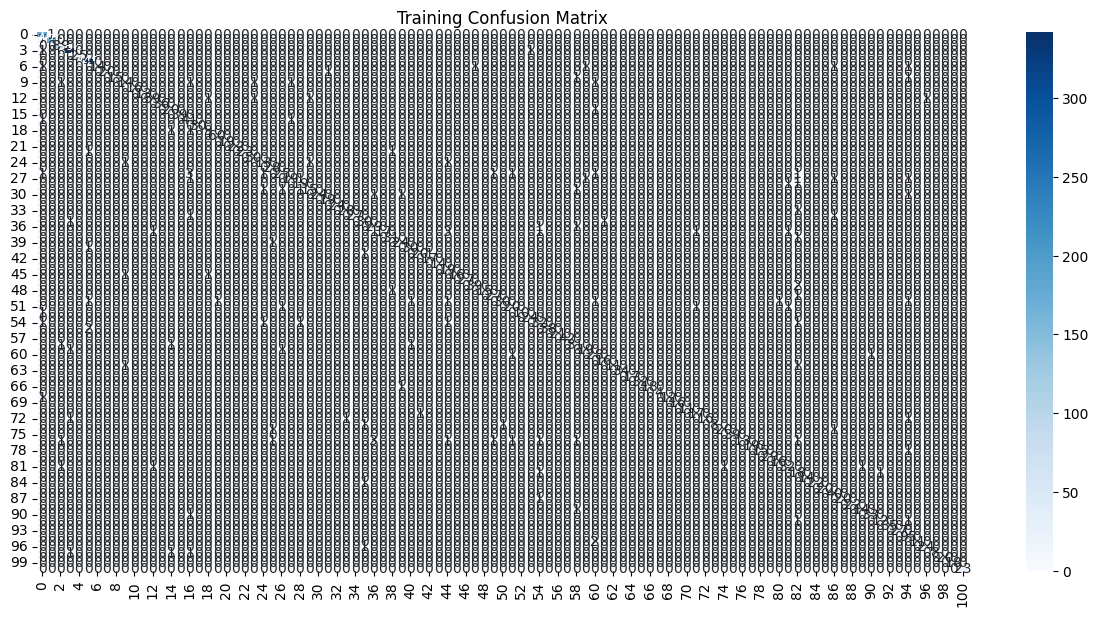

Validation Confusion Matrix


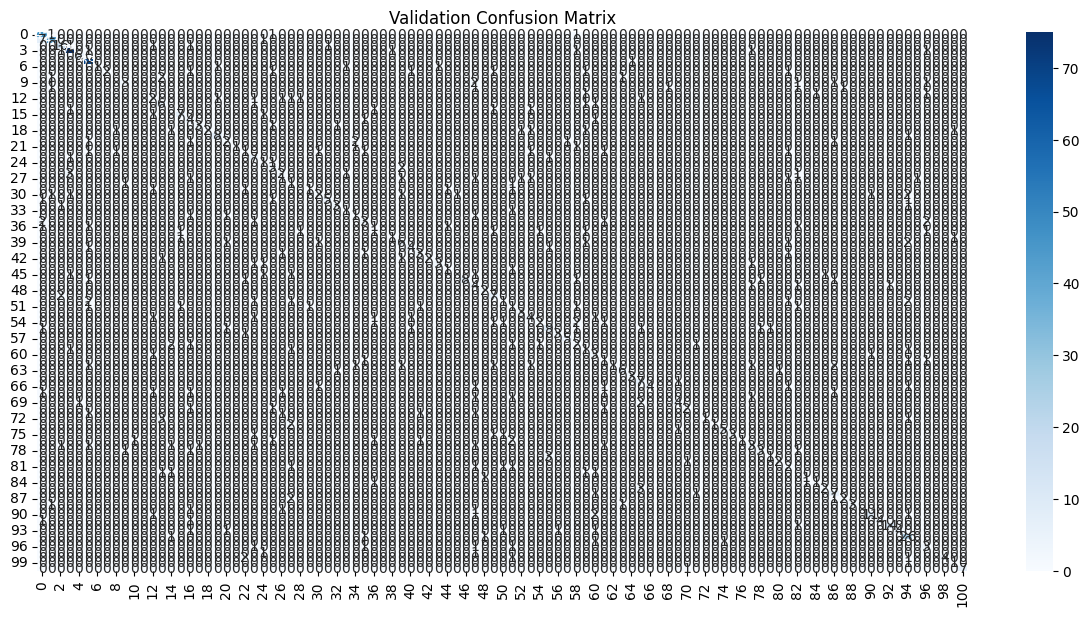

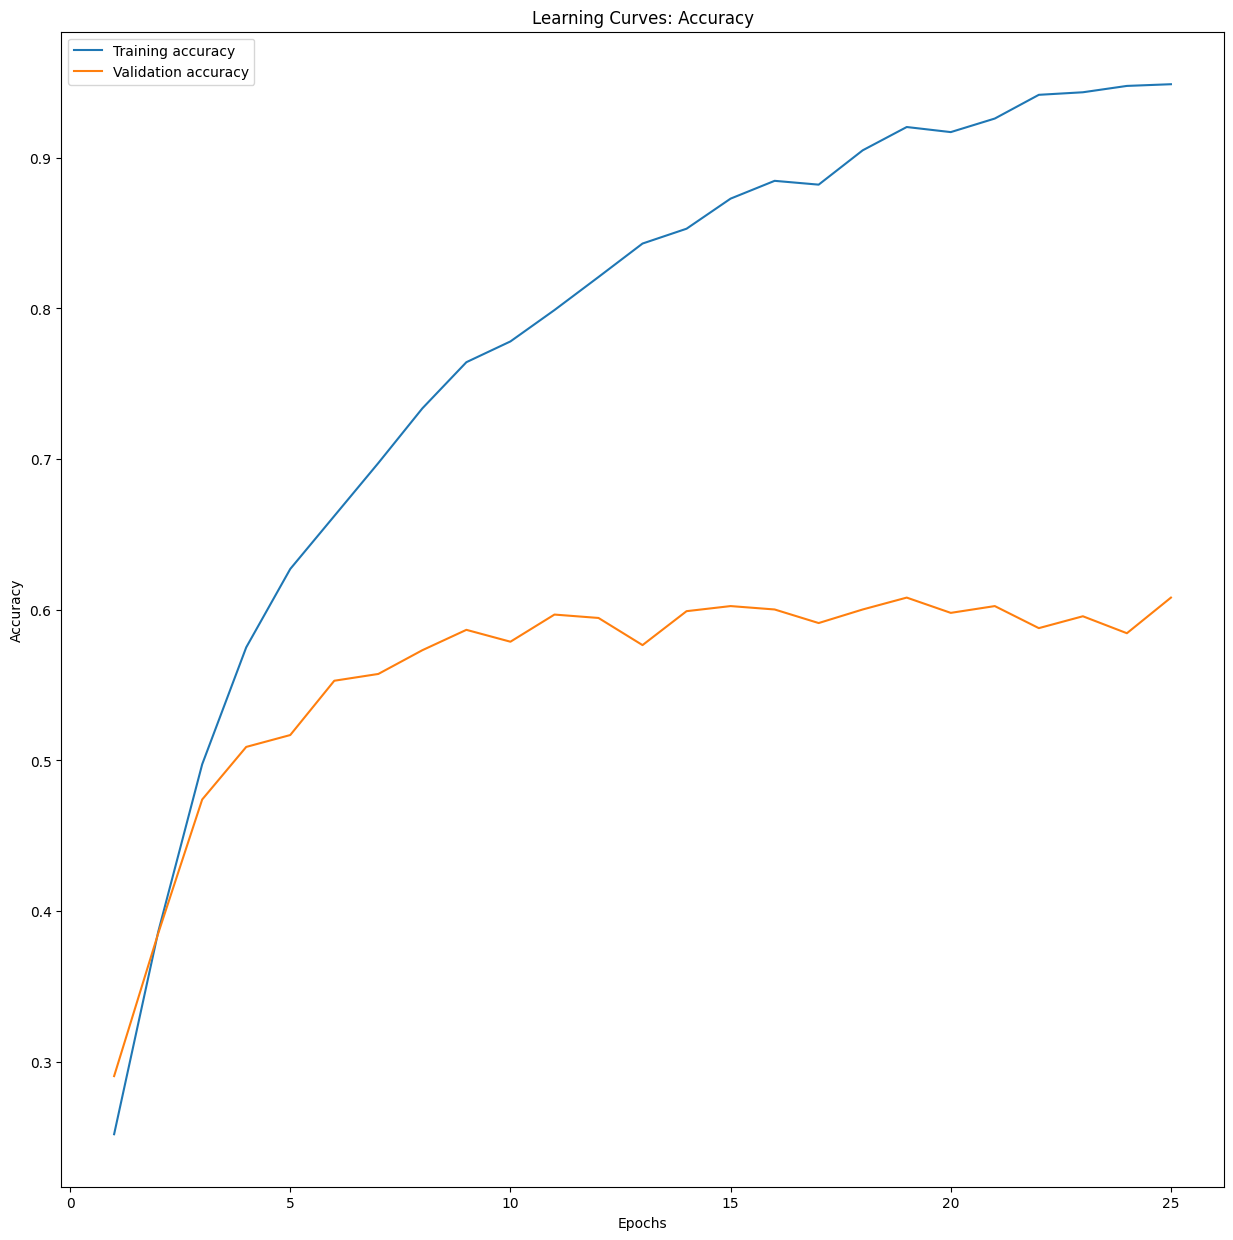

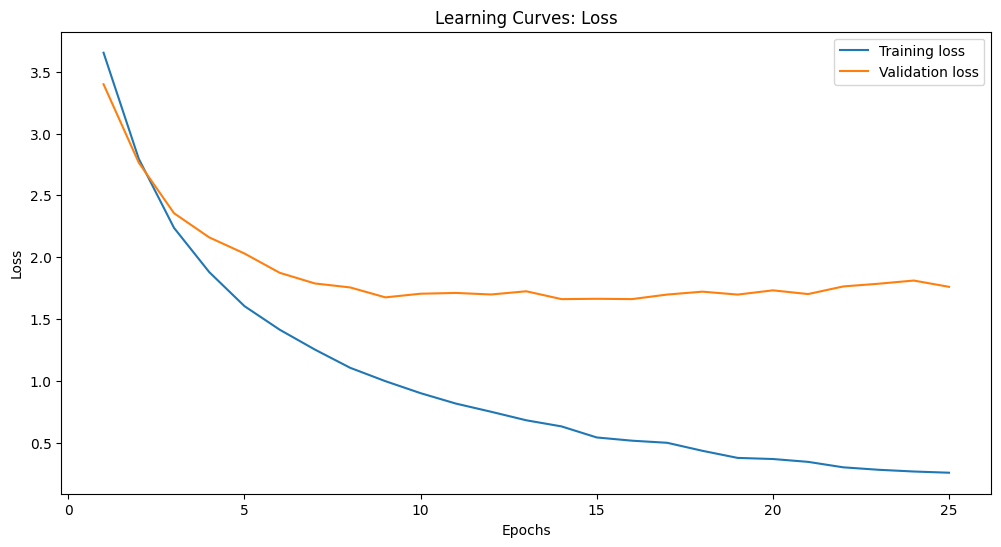

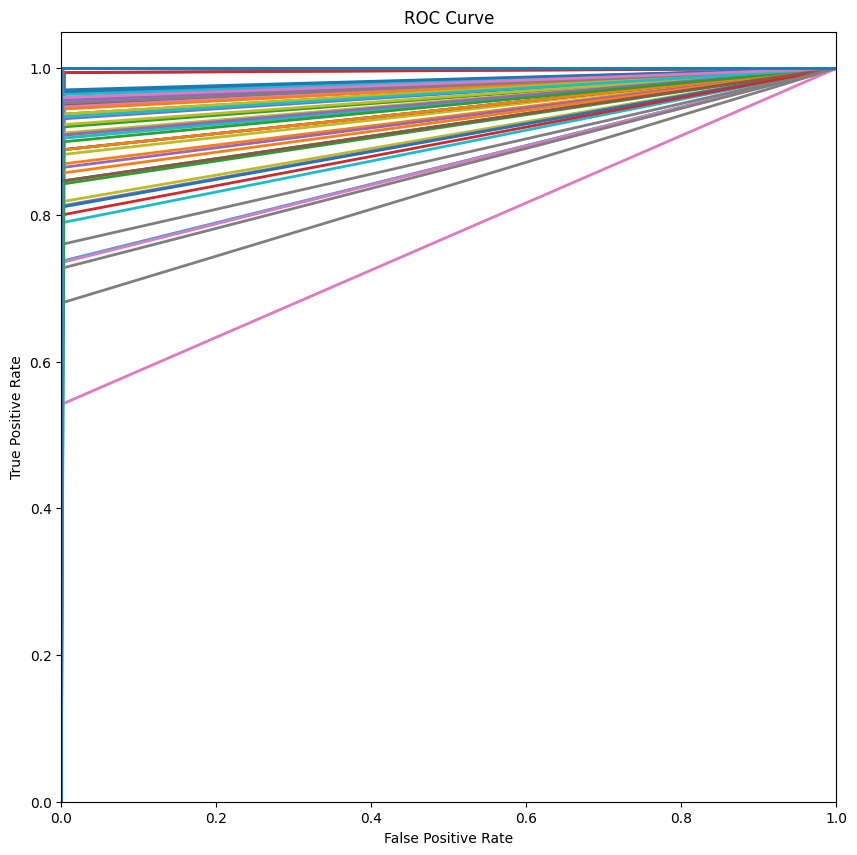

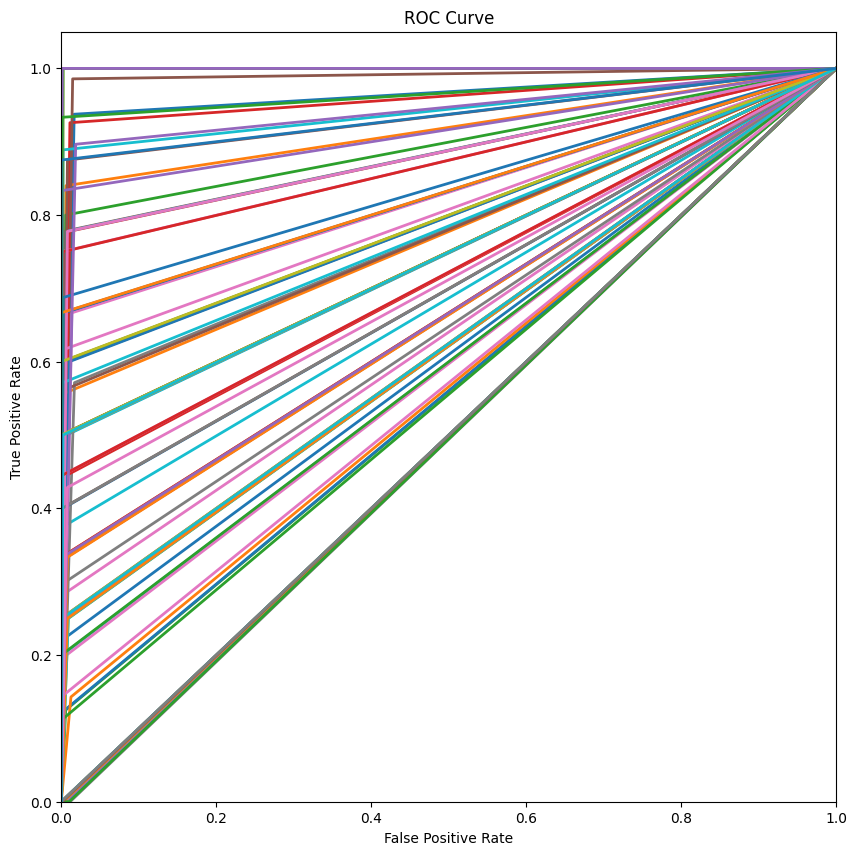

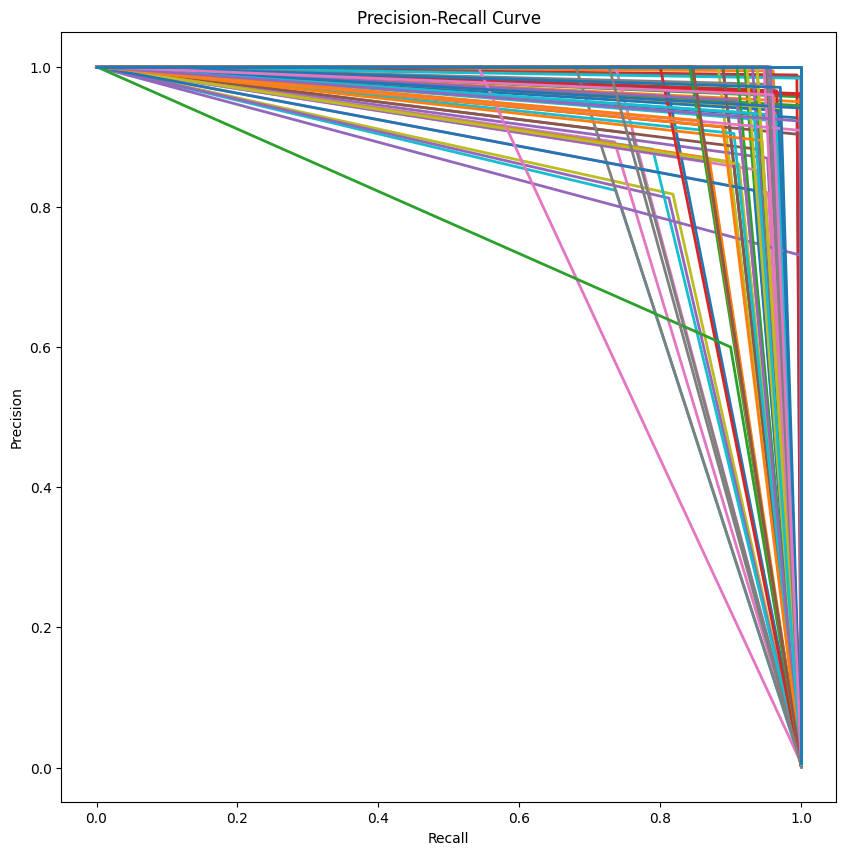

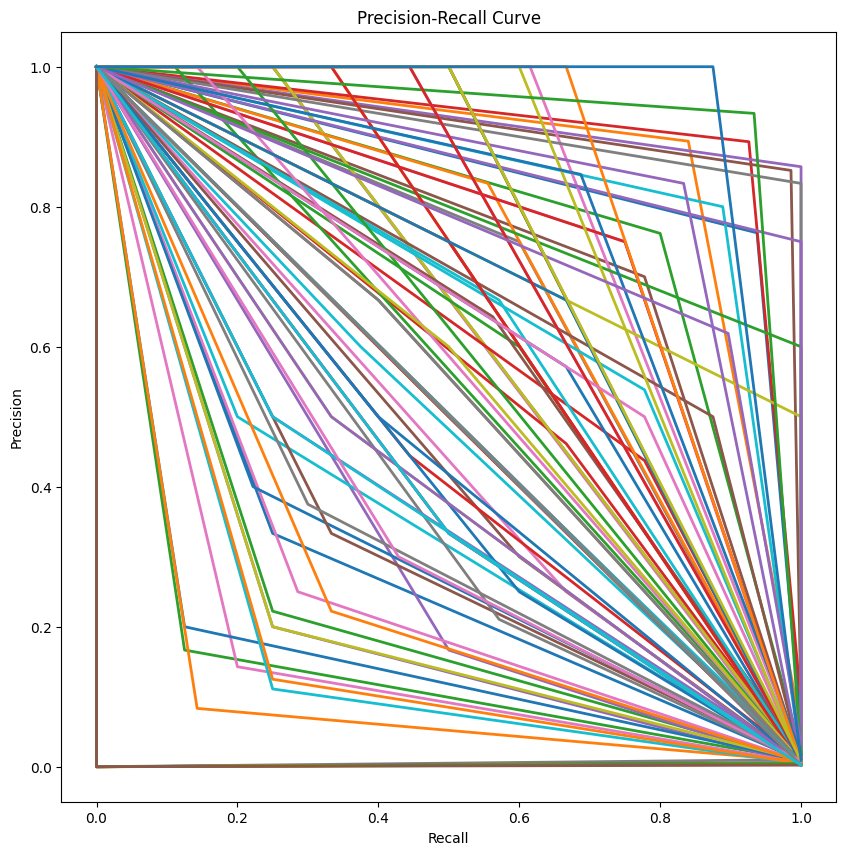

Training Top-1 Error Rate: 4.33%
Validation Top-1 Error Rate: 39.19%


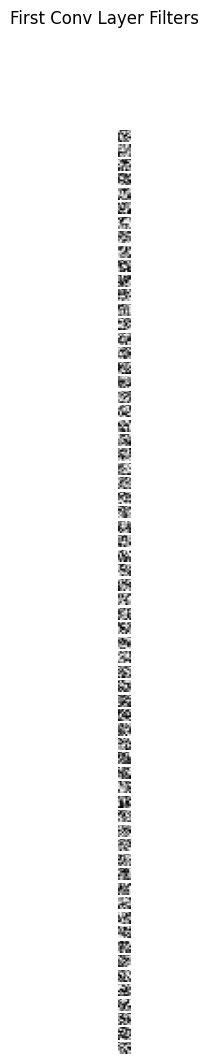

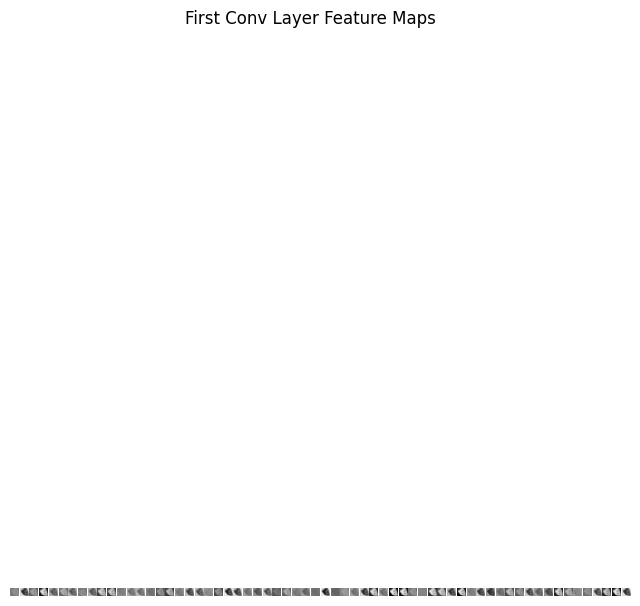

Evaluating the model resnet
Evaluating the model ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, 

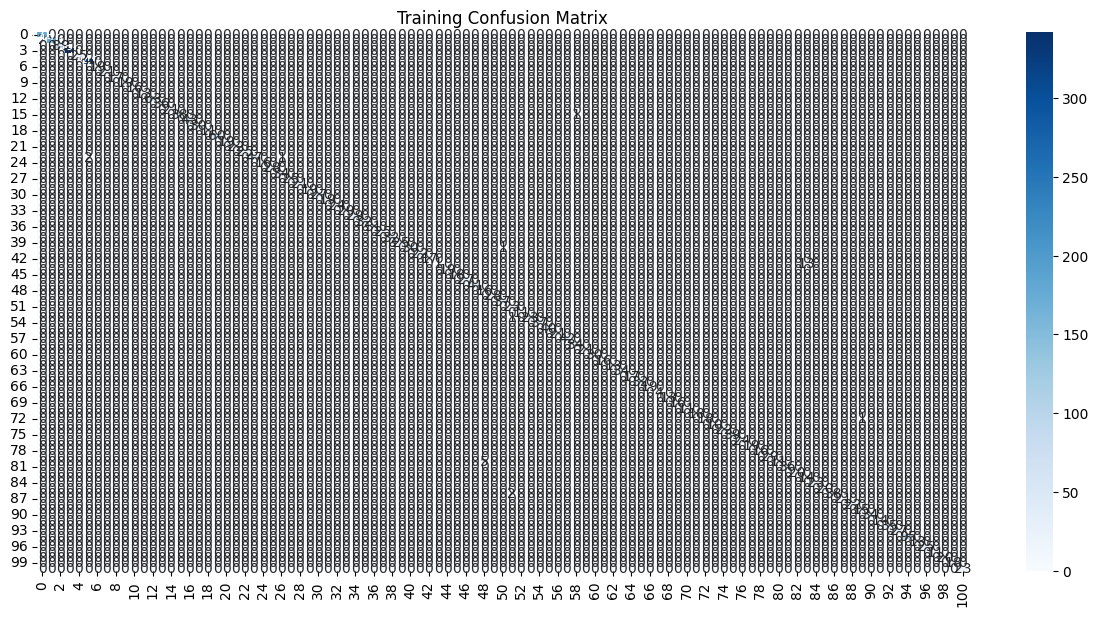

Validation Confusion Matrix


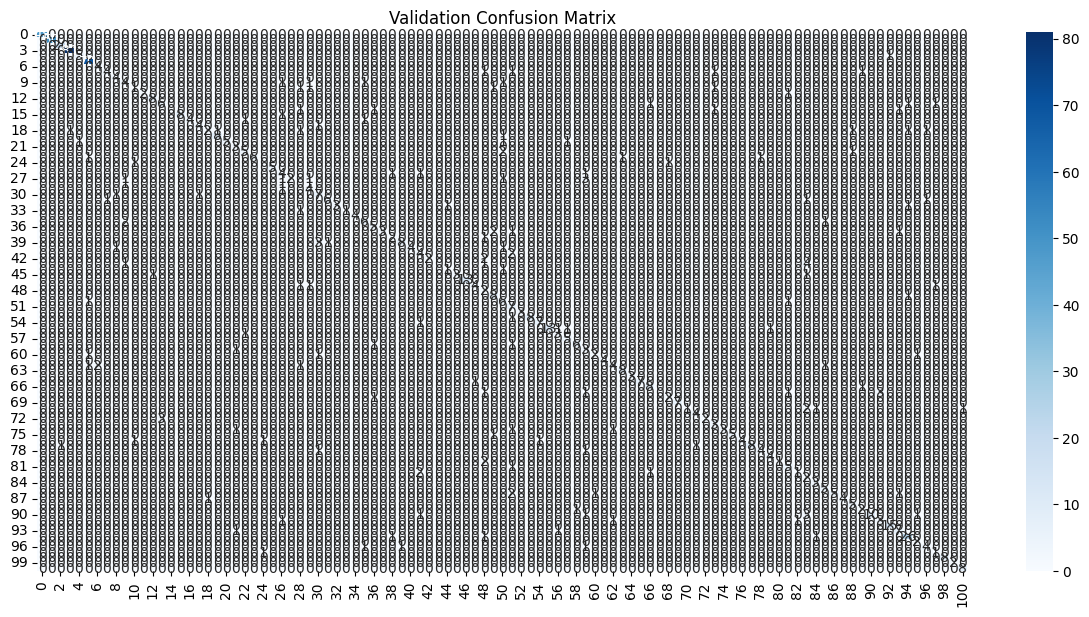

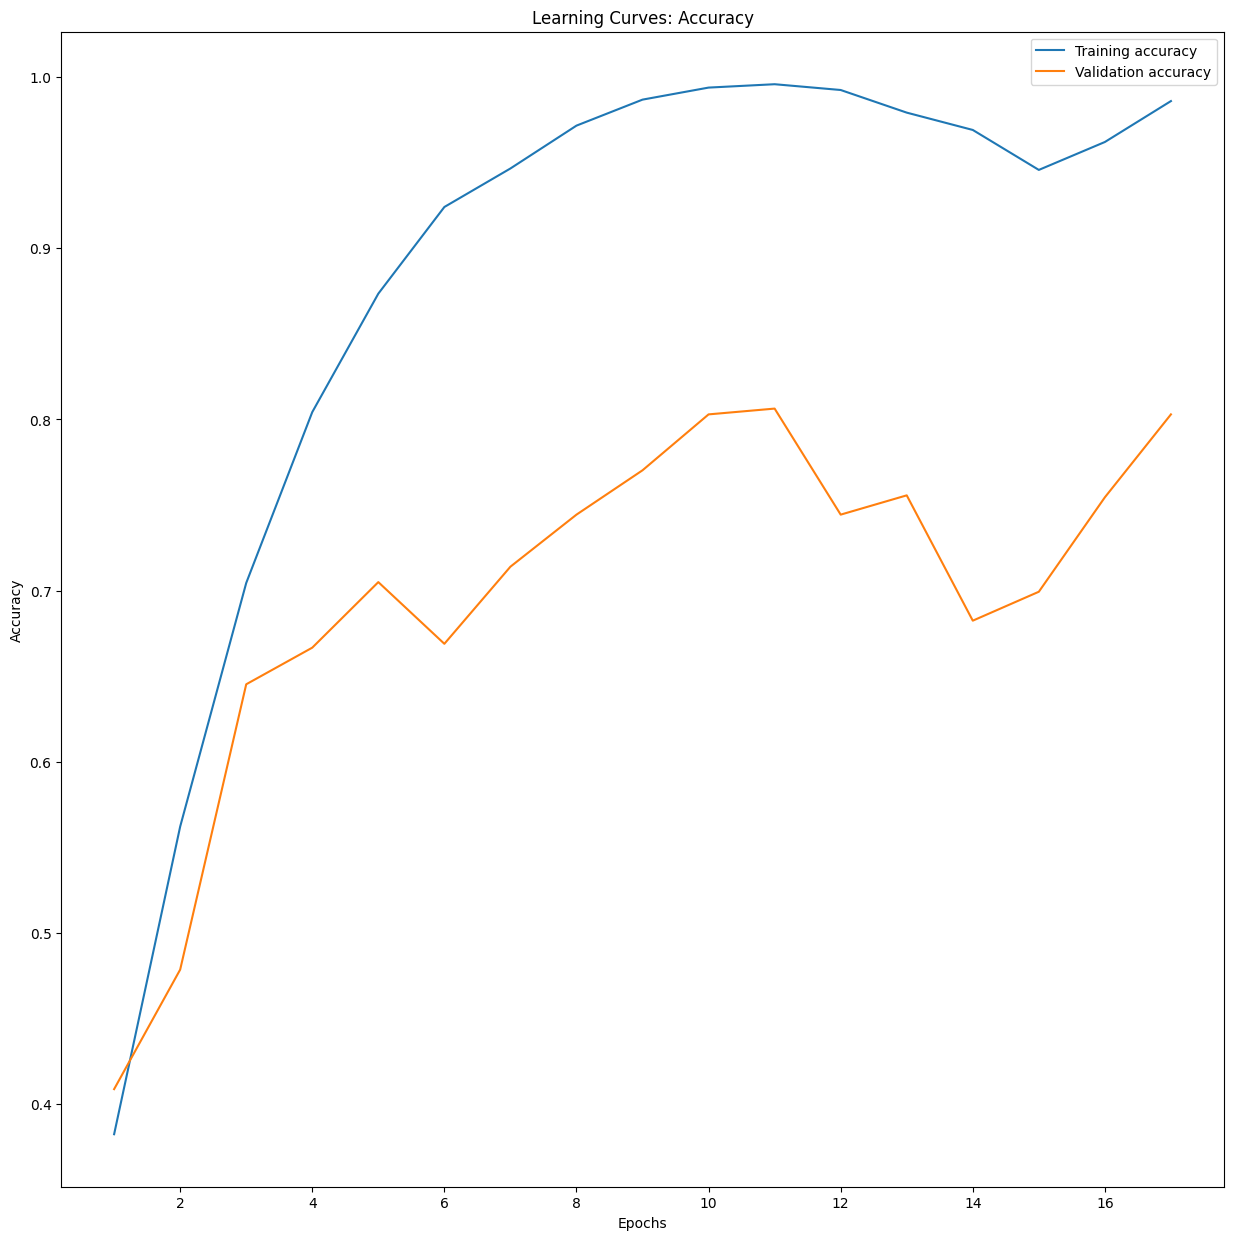

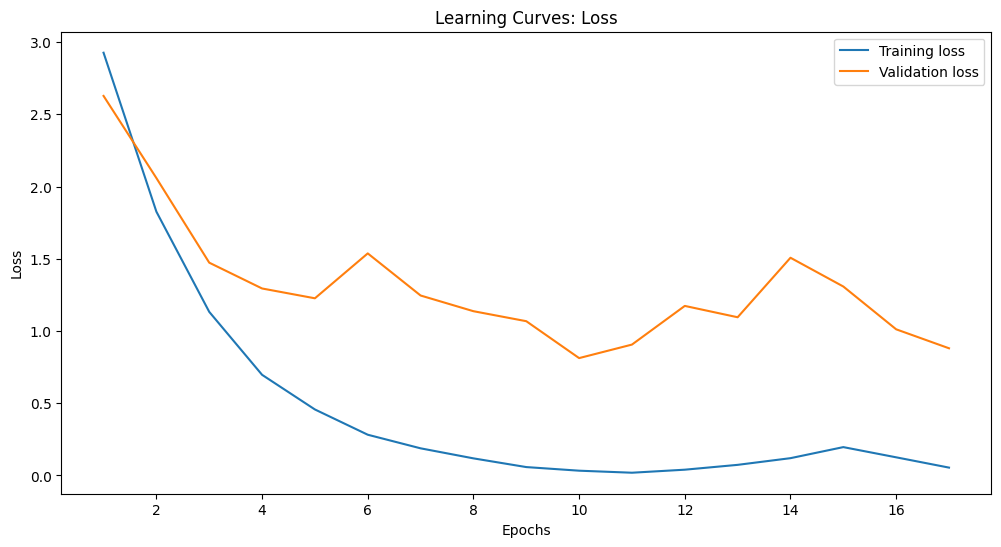

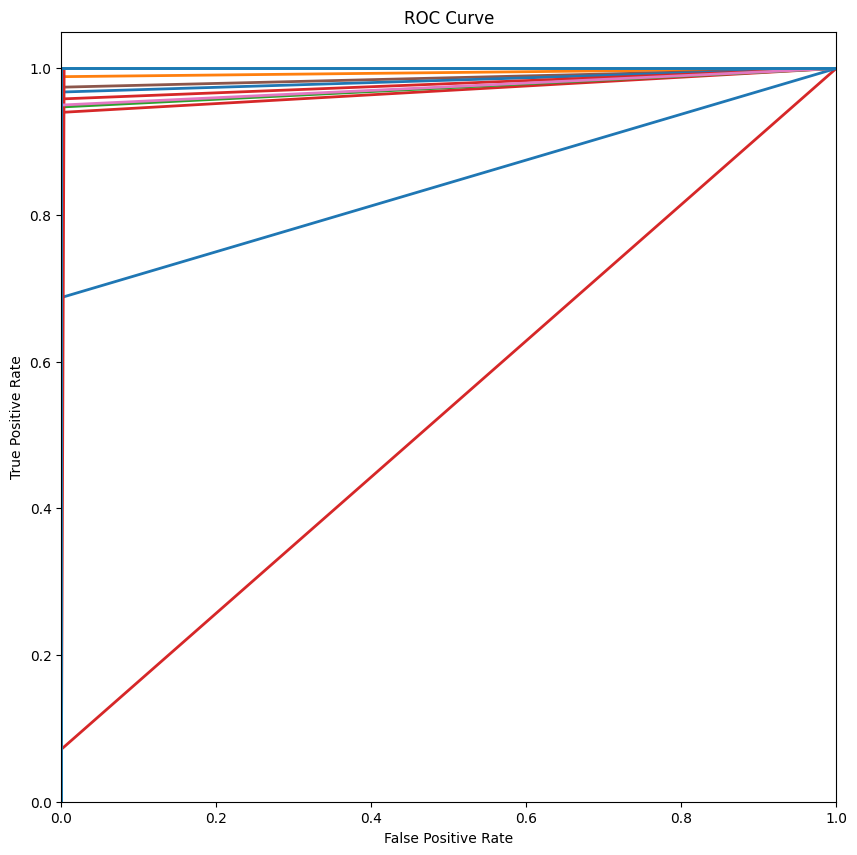

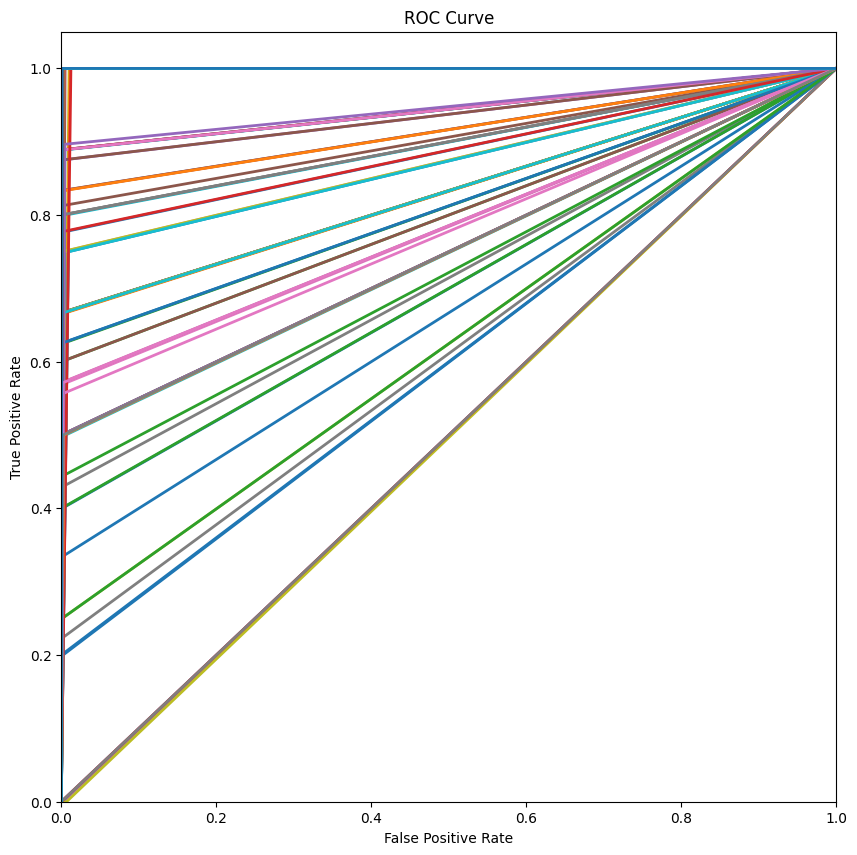

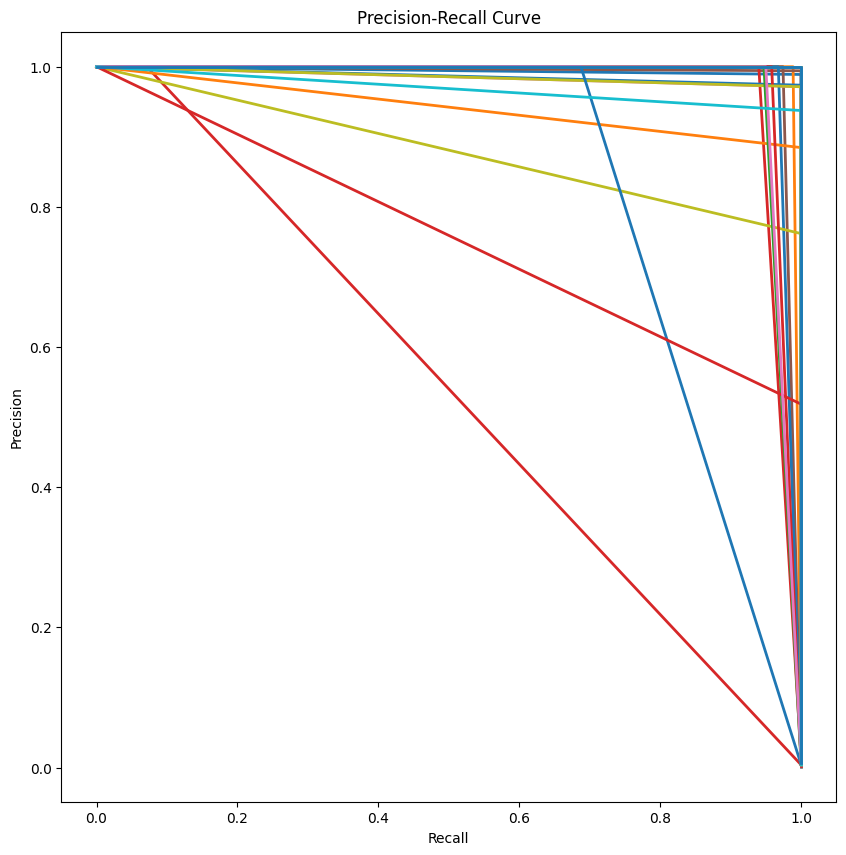

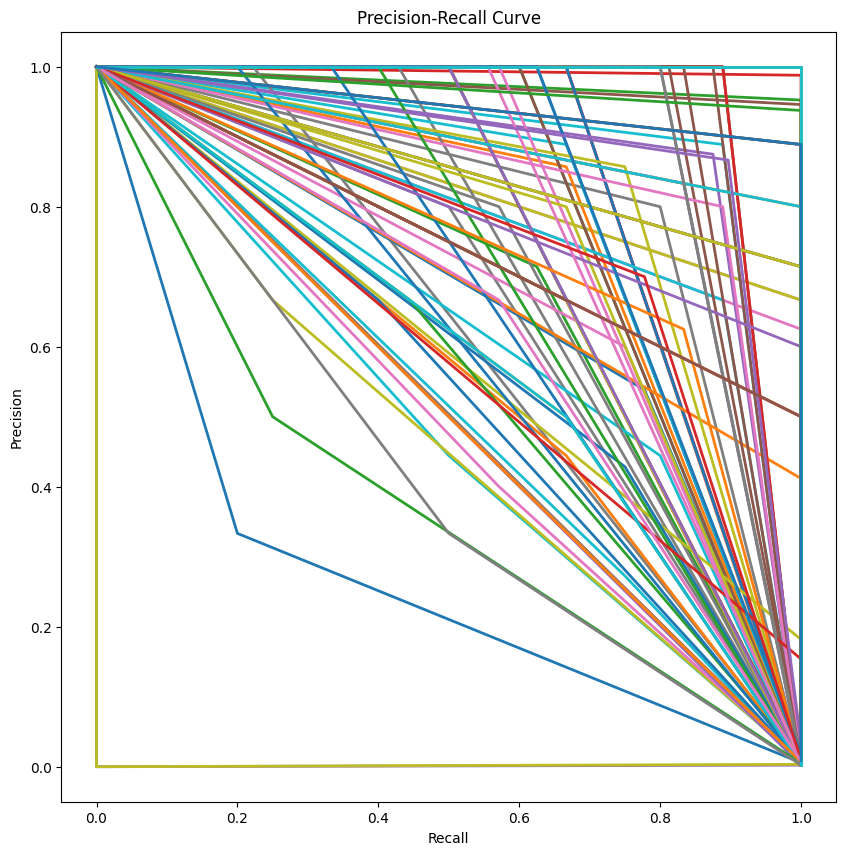

Training Top-1 Error Rate: 0.82%
Validation Top-1 Error Rate: 19.37%


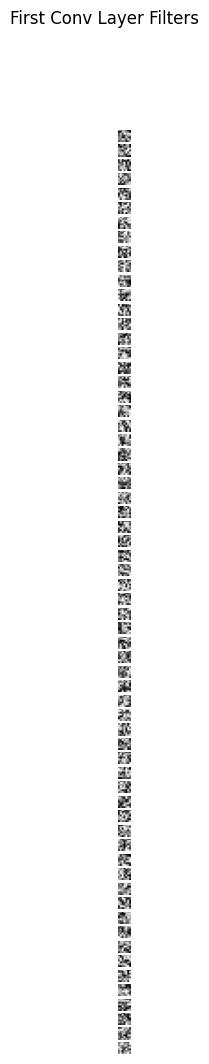

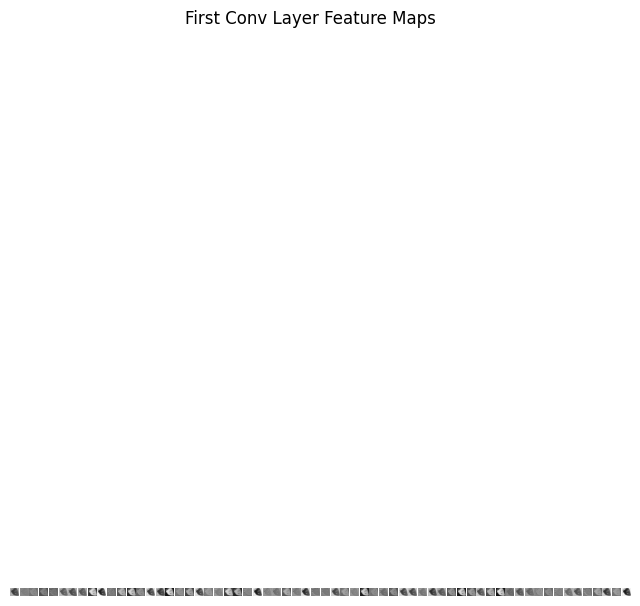

In [221]:
for name, model_result in models_results.items():
    print(f"Evaluating the model {name}")
    evaluate_model(model_result, val_loader, train_loader, models_to_train.get(name))

# Results explanation
All models were trained using Addam optimizer with cross entropy for 25 rpochs with batch size of 64.
We see a bit of the overfitting in the CNN model
The general results are:

Accuracy — 0.81, average precision 0.84 (ResNet)
Accuracy — 0.61 (Frozen ResNet)
Accuracy — 0.52 (Plain CNN)

Validation Top-1 Error Rate: 19.37% for ResNet



4.1 What kind of features did filters extract?


4.2 Do you have "blind" filters that didn't learn anything? Why? How could you fix that?
From the displayed filters its clearly seen that some filters extracted more important and efficient features than the others. However, I wouldn't call any of ResNet and FrozenResNet filters blind, while there is a few 'blind' filters in CNN mdodel.

4.3 Does your model consider the background of the inputs?
No, they're just trying to extract different features, regardless of are those features parts of the background or not.

4.4 Does your model consider the color of the inputs?
No, its in GrayScale
